In [471]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [472]:
configs = [
    "Surrogate_Paranoia_V1",
    "Surrogate_Paranoia_V2",
    "Surrogate_Paranoia_V3",
    "Surrogate_Data_V5",
]

target_names = [
    "2024-06-01_19-29-44_forestgreen-history",
    "2024-06-03_03-24-49_azure-tax",
    "2024-06-02_19-01-47_mintcream-hotel",
    "2024-06-01_11-41-52_royalblue-stay",
    "2024-06-02_03-06-38_navajowhite-fund",
    "2024-06-02_10-45-26_plum-early",
    "2024-06-03_21-29-45_lightslategray-feel",
    "2024-06-04_10-20-22_springgreen-pattern",
    "2024-06-03_11-16-37_steelblue-wrong",
    "2024-06-04_08-05-08_green-might",
    "2024-06-03_23-40-39_aquamarine-less",
    "2024-06-03_19-18-06_lavender-final",
    "2024-06-04_20-54-46_cadetblue-want",
    "2024-06-05_13-50-21_olivedrab-marriage",
    "2024-06-05_04-30-29_coral-million",
    "2024-06-05_06-32-02_blueviolet-rather",
    "2024-06-04_12-34-40_sienna-education",
    "2024-06-05_15-58-09_gold-administration",
    "2024-04-28_07-18-23_lightcoral-pretty",
    "2024-04-28_22-59-40_blueviolet-physical",
    "2024-05-14_22-20-02_lightpink-medical",
    "2024-04-10_13-36-12_darkcyan-why",
    "2024-04-29_15-29-39_darkkhaki-quickly",
    "2024-04-28_15-07-53_aliceblue-suddenly",
]

ignore = []

In [473]:
# def find_config(workspace):
#     with open(f"/app/wafcraft/data/prepared/{workspace}/config.txt", "r") as f:
#         config = f.read()
#     # parse the NAME: (format is NAME: Surrogate_Data_V3)
#     name = config.split("NAME: ")[1].split("\n")[0]
#     return name
def find_workspaces(config):
    prepared_dir = "/app/wafcraft/data/prepared"
    this_results_dir = "/app/wafcraft/results/paranoia_experiments"
    workspace_names_with_targetunderscore = os.listdir(this_results_dir)
    # split the target names from the workspace names at the first underscore
    workspace_names = [name.split("_", 1)[1] for name in workspace_names_with_targetunderscore]
    search_str = f": {config}\n"
    matching_workspaces = []
    for workspace in workspace_names:
        with open(f"{prepared_dir}/{workspace}/config.txt", "r") as f:
            config = f.read()
        if search_str in config:
            matching_workspaces.append(workspace)
    return matching_workspaces

def get_transferabilities(target):
    transferabilities = {}
    data = pd.read_csv(f"/app/wafcraft/results/paranoia_experiments/target_{target}/transferability.csv")
    for index, row in data.iterrows():
        if row["surrogate_workspace"] not in ignore:
            if row["config"] not in transferabilities:
                transferabilities[row["config"]] = []
            transferabilities[row["config"]].append(row["samples_evaded_percentage"])
    return transferabilities

def mean_transferabilities_single_target(transferabilities):
    means = {}
    for config, values in transferabilities.items():
        means[config] = sum(values) / len(values)
    return means

In [474]:
# create a dictionary of workspaces for each config
workspaces = {}
for config in configs:
    this_workspaces = find_workspaces(config)
    this_workspaces = [w for w in this_workspaces if w not in ignore] # remove the ignored workspaces
    workspaces[config] = this_workspaces

print(workspaces)

{'Surrogate_Paranoia_V1': ['2024-06-02_10-45-26_plum-early', '2024-06-01_11-41-52_royalblue-stay', '2024-06-02_19-01-47_mintcream-hotel', '2024-06-02_03-06-38_navajowhite-fund', '2024-06-01_19-29-44_forestgreen-history', '2024-06-03_03-24-49_azure-tax'], 'Surrogate_Paranoia_V2': ['2024-06-04_10-20-22_springgreen-pattern', '2024-06-03_11-16-37_steelblue-wrong', '2024-06-03_21-29-45_lightslategray-feel', '2024-06-04_08-05-08_green-might', '2024-06-03_23-40-39_aquamarine-less', '2024-06-03_19-18-06_lavender-final'], 'Surrogate_Paranoia_V3': ['2024-06-04_20-54-46_cadetblue-want', '2024-06-05_15-58-09_gold-administration', '2024-06-04_12-34-40_sienna-education', '2024-06-05_06-32-02_blueviolet-rather', '2024-06-05_04-30-29_coral-million', '2024-06-05_13-50-21_olivedrab-marriage'], 'Surrogate_Data_V5': ['2024-04-28_07-18-23_lightcoral-pretty', '2024-04-29_15-29-39_darkkhaki-quickly', '2024-04-28_22-59-40_blueviolet-physical', '2024-04-28_15-07-53_aliceblue-suddenly', '2024-05-14_22-20-02_lig

In [475]:
# Create a dictionary of transferabilities for each target
# means_per_target will look like this:
# {
#     "Surrogate_Data_V5": {
#         "Surrogate_Data_V5": 0.9167245153079279,
#         "Surrogate_SVM_V1": 0.47909912998232085,
#         "Surrogate_GBoost_V1": 0.5867911914243019,
#         "Surrogate_NaiveBayes_V1": 0.349217340248029,
#         "Surrogate_LogReg_V1": 0.42137737341797754,
#         "Surrogate_KNN_V1": 0.31808236561329783,
#     },
#     "Surrogate_GBoost_V1": {
#         "Surrogate_Data_V5": 0.7089505536035176,
#         "Surrogate_SVM_V1": 0.6619962302807056,
#         ...
#     },
#     ...
# }

means_per_target = {}

for target_config in configs:
    target_workspaces = find_workspaces(target_config)
    print(f"{target_config}:\n{target_workspaces}\n\n")
    target_workspaces = [
        w for w in target_workspaces if w not in ignore
    ]  # remove the ignored workspaces

    all_means_of_this_target_conf = {}
    all_means_of_this_target_conf_mean = {}
    for target in target_workspaces:
        transferabilities = get_transferabilities(target)
        means = mean_transferabilities_single_target(transferabilities)
        for surrogate_config, mean in means.items():
            if surrogate_config not in all_means_of_this_target_conf:
                all_means_of_this_target_conf[surrogate_config] = []
            all_means_of_this_target_conf[surrogate_config].append(mean)
    for surrogate_config, means in all_means_of_this_target_conf.items():
        all_means_of_this_target_conf_mean[surrogate_config] = sum(means) / len(means)

    means_per_target[target_config] = all_means_of_this_target_conf_mean

print(means_per_target)

Surrogate_Paranoia_V1:
['2024-06-02_10-45-26_plum-early', '2024-06-01_11-41-52_royalblue-stay', '2024-06-02_19-01-47_mintcream-hotel', '2024-06-02_03-06-38_navajowhite-fund', '2024-06-01_19-29-44_forestgreen-history', '2024-06-03_03-24-49_azure-tax']


Surrogate_Paranoia_V2:
['2024-06-04_10-20-22_springgreen-pattern', '2024-06-03_11-16-37_steelblue-wrong', '2024-06-03_21-29-45_lightslategray-feel', '2024-06-04_08-05-08_green-might', '2024-06-03_23-40-39_aquamarine-less', '2024-06-03_19-18-06_lavender-final']


Surrogate_Paranoia_V3:
['2024-06-04_20-54-46_cadetblue-want', '2024-06-05_15-58-09_gold-administration', '2024-06-04_12-34-40_sienna-education', '2024-06-05_06-32-02_blueviolet-rather', '2024-06-05_04-30-29_coral-million', '2024-06-05_13-50-21_olivedrab-marriage']


Surrogate_Data_V5:
['2024-04-28_07-18-23_lightcoral-pretty', '2024-04-29_15-29-39_darkkhaki-quickly', '2024-04-28_22-59-40_blueviolet-physical', '2024-04-28_15-07-53_aliceblue-suddenly', '2024-05-14_22-20-02_lightpink

In [476]:
res = {
    "Surrogate_Paranoia_V1": {
        "Surrogate_Paranoia_V1": 0.9996666666666667,
        "Surrogate_Paranoia_V2": 0.9780555555555556,
        "Surrogate_Paranoia_V3": 0.9574305555555555,
        "Surrogate_Data_V5": 0.9527777777777778,
    },
    "Surrogate_Paranoia_V2": {
        "Surrogate_Paranoia_V1": 0.13729166666666667,
        "Surrogate_Paranoia_V2": 0.9560000000000001,
        "Surrogate_Paranoia_V3": 0.8325694444444446,
        "Surrogate_Data_V5": 0.82375,
    },
    "Surrogate_Paranoia_V3": {
        "Surrogate_Paranoia_V1": 0.07229166666666667,
        "Surrogate_Paranoia_V2": 0.5022916666666667,
        "Surrogate_Paranoia_V3": 0.8971666666666667,
        "Surrogate_Data_V5": 0.8825,
    },
    "Surrogate_Data_V5": {
        "Surrogate_Paranoia_V1": 0.07923611111111112,
        "Surrogate_Paranoia_V2": 0.5275,
        "Surrogate_Paranoia_V3": 0.9365277777777777,
        "Surrogate_Data_V5": 0.9167500000000001,
    },
}

In [477]:
# Create a heatmap of transferabilities
# Convert the entries from 0.123 to percentages
for target_config, transferabilities in means_per_target.items():
    for surrogate_config, mean in transferabilities.items():
        means_per_target[target_config][surrogate_config] = mean * 100

config_names = {
    "Surrogate_Paranoia_V1": "PL1",
    "Surrogate_Paranoia_V2": "PL2",
    "Surrogate_Paranoia_V3": "PL3",
    "Surrogate_Data_V5": "PL4",
}

df = pd.DataFrame(means_per_target)

df.rename(index=config_names, columns=config_names, inplace=True)

order = ["PL1", "PL2", "PL3", "PL4"]
df = df.loc[order, order]
df = df.T

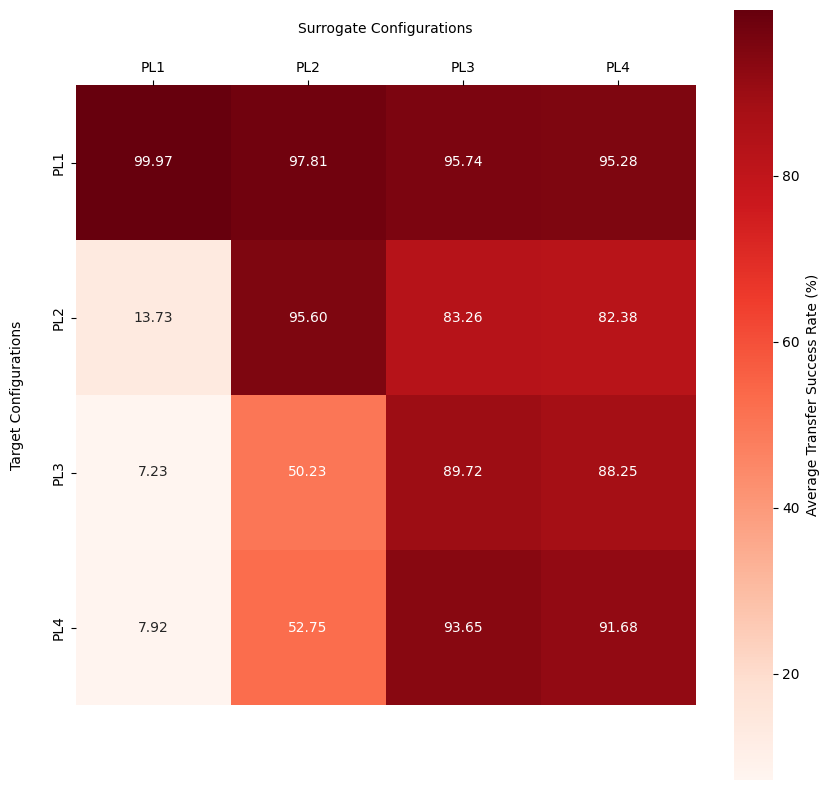

In [478]:
# Create a heatmap
plt.figure(figsize=(10, 10))
# plt.title("Heatmap of Transferability Scores")


ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "Average Transfer Success Rate (%)"},
    square=True,
)

ax.set_xlabel("Surrogate Configurations", labelpad=20)
ax.set_ylabel("Target Configurations", labelpad=20)

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

plt.show()

In [479]:
# Calculate the average transferability for each target config

print("Average transferability for each target config (the lower, the \"safer\" the architecture):")
print(df.mean(axis=1).sort_values(ascending=True))
print("Average transferability for each target config, excluding the self-transferability:")
df_no_self = df.copy()
for config in df_no_self.columns:
    df_no_self.loc[config, config] = None
print(df_no_self.mean(axis=1).sort_values(ascending=True))

print("Average transferability for each surrogate config (the higher, the \"better\" for attacker):")
print(df.mean(axis=0).sort_values(ascending=False))
print("Average transferability for each surrogate config, excluding the self-transferability:")
print(df_no_self.mean(axis=0).sort_values(ascending=False))

Average transferability for each target config (the lower, the "safer" the architecture):
PL3    58.856250
PL4    61.500347
PL2    68.740278
PL1    97.198264
dtype: float64
Average transferability for each target config, excluding the self-transferability:
PL3    48.569444
PL4    51.442130
PL2    59.787037
PL1    96.275463
dtype: float64
Average transferability for each surrogate config (the higher, the "better" for attacker):
PL3    90.592361
PL4    89.394444
PL2    74.096181
PL1    32.212153
dtype: float64
Average transferability for each surrogate config, excluding the self-transferability:
PL3    90.884259
PL4    88.634259
PL2    66.928241
PL1     9.627315
dtype: float64


In [480]:
# calculate the highest distances between transferability from architecture A to architecture B compared to B to A

print("Differences between transferability from architecture A to architecture B compared to B to A:")
diffs = {}
for config in df.columns:
    diffs[config] = {}
    for config2 in df.columns:
        diffs[config][config2] = df.loc[config, config2] - df.loc[config2, config]

diffs_df = pd.DataFrame(diffs)

print(diffs_df)

# print the row and column names of the highest differences
print("Highest differences:")
for config in diffs_df.columns:
    print(f"{config}:")
    print(diffs_df[config].sort_values(ascending=False).head(3))
    print("\n")

Differences between transferability from architecture A to architecture B compared to B to A:
           PL1        PL2        PL3        PL4
PL1   0.000000 -84.076389 -88.513889 -87.354167
PL2  84.076389   0.000000 -33.027778 -29.625000
PL3  88.513889  33.027778   0.000000   5.402778
PL4  87.354167  29.625000  -5.402778   0.000000
Highest differences:
PL1:
PL3    88.513889
PL4    87.354167
PL2    84.076389
Name: PL1, dtype: float64


PL2:
PL3    33.027778
PL4    29.625000
PL2     0.000000
Name: PL2, dtype: float64


PL3:
PL3     0.000000
PL4    -5.402778
PL2   -33.027778
Name: PL3, dtype: float64


PL4:
PL3     5.402778
PL4     0.000000
PL2   -29.625000
Name: PL4, dtype: float64


